In [1]:
import numpy as np
import pandas as pd

from scipy import polyval, stats
import math
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.formula.api as sf
import statsmodels.api as sm

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

from collections import Counter

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv('resource/Barcelona airbnb 10.2020.csv')

In [4]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,21974,Comf. double room/private bathroom,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37973,2.17631,Private room,55,3,2,2017-11-06,0.05,3,139
1,23197,Forum DeLuxe 5 mins Walk To CCIB Center & Sea★,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41291,2.22063,Entire home/apt,180,3,52,2019-12-15,0.45,2,358
2,32711,Sagrada Familia area - Còrsega 1,135703,Nick,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40566,2.17015,Entire home/apt,109,2,63,2020-02-22,0.56,5,0
3,34241,Private Double room - Plaza Real,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37916,2.17535,Private room,40,30,8,2013-07-15,0.06,3,0
4,34981,VIDRE HOME PLAZA REAL on LAS RAMBLAS,73163,Andres,Ciutat Vella,el Barri Gòtic,41.37978,2.17623,Entire home/apt,131,4,149,2020-03-11,1.22,3,92


In [5]:
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['id' 'host_id' 'latitude' 'longitude' 'price' 'minimum_nights'
 'number_of_reviews' 'reviews_per_month' 'calculated_host_listings_count'
 'availability_365']


                                  Shape and data types of the data 
                                     (генеральная совокупность)

In [6]:
df.shape

(19896, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19896 entries, 0 to 19895
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19896 non-null  int64  
 1   name                            19884 non-null  object 
 2   host_id                         19896 non-null  int64  
 3   host_name                       19889 non-null  object 
 4   neighbourhood_group             19896 non-null  object 
 5   neighbourhood                   19896 non-null  object 
 6   latitude                        19896 non-null  float64
 7   longitude                       19896 non-null  float64
 8   room_type                       19896 non-null  object 
 9   price                           19896 non-null  int64  
 10  minimum_nights                  19896 non-null  int64  
 11  number_of_reviews               19896 non-null  int64  
 12  last_review                     

In [8]:
# Список долей отсутствующих записей для каждого признака
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 30%
calculated_host_listings_count - 0%
availability_365 - 0%


                                    Data cleaning

### Отсутствующие данные

In [9]:
# Внесение недостающих значений в столбцы name и host_name
df['name'] = df['name'].fillna('MISSING')
df['host_name'] = df['host_name'].fillna('MISSING')

In [10]:
# проверка заполнения недостающих значений 'name'
missing_df = df['name'].str.contains('MISSING')
df[missing_df]['name']

1869    MISSING
2285    MISSING
2685    MISSING
2698    MISSING
2804    MISSING
2890    MISSING
3001    MISSING
3012    MISSING
3358    MISSING
4533    MISSING
4561    MISSING
4661    MISSING
Name: name, dtype: object

Text(0.5, 1.0, 'Тепловая карта пропущенных значений')

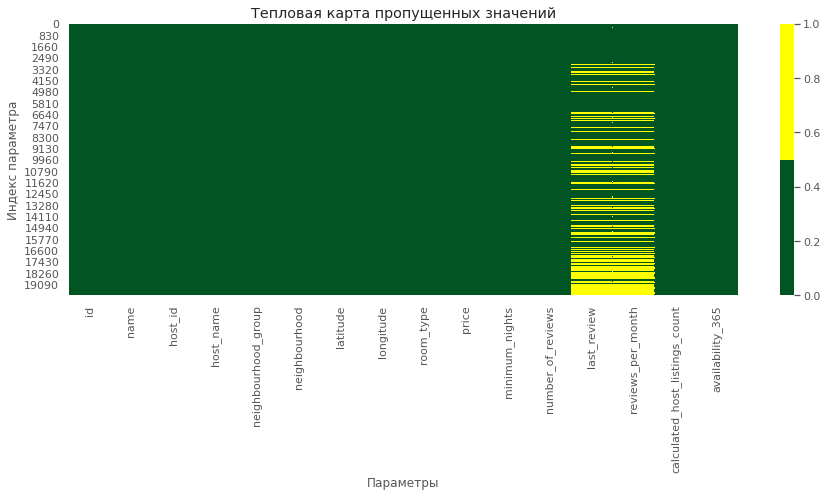

In [11]:
# Отсутствующие значения на тепловой карте
cols = df.columns
colours = ['#005522', '#ffff00']
# желтый - пропущенные данные
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))
plt.xlabel('Параметры')
plt.ylabel('Индекс параметра')
plt.title('Тепловая карта пропущенных значений')

Диаграмма корреляции для визуализации метрики корреляции между всеми возможными парами числовых переменных в данном наборе данных 

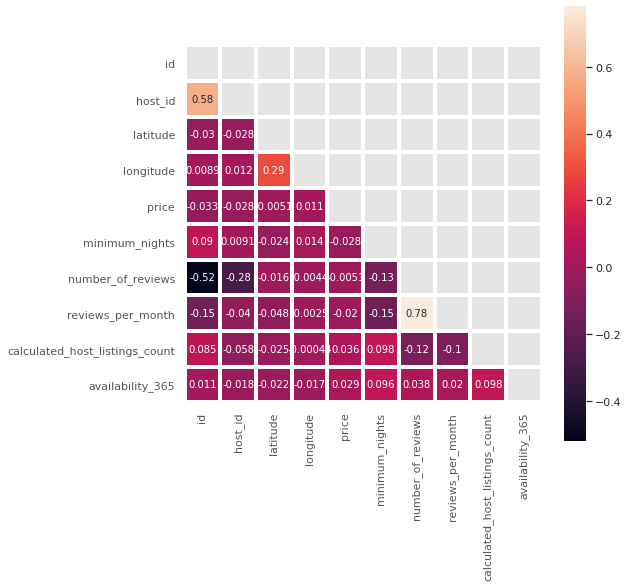

In [12]:
# матрица корреляции между атрибутами объекта
fig, ax = plt.subplots(figsize=(8, 8))
corr = df[[
    'id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights',
    'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',
    'availability_365'
]].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('dark'):
    ax = sns.heatmap(corr,
                     mask=mask,
                     square=True,
                     cbar=True,
                     annot=True,
                     linewidths=3)

In [13]:
#фильтр по пустым ячейкам в столбце reviews_per_month
filtered_nullable = df[df['reviews_per_month'].isnull()]
len(filtered_nullable)

5877

In [14]:
#выбор 2х столбцов по заданному фильтру
filtered_nullable = filtered_nullable[[
    'number_of_reviews', 'reviews_per_month'
]]
# количество отзывов при нулевом значении параметра в месяц
filtered_nullable['number_of_reviews'].value_counts()

0    5877
Name: number_of_reviews, dtype: int64

In [15]:
# замененна значения NAN новым значением 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

In [16]:
# Проверка долей отсутствующих записей для каждого признака после внесения недостающих значений
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing * 100)))

id - 0%
name - 0%
host_id - 0%
host_name - 0%
neighbourhood_group - 0%
neighbourhood - 0%
latitude - 0%
longitude - 0%
room_type - 0%
price - 0%
minimum_nights - 0%
number_of_reviews - 0%
last_review - 30%
reviews_per_month - 0%
calculated_host_listings_count - 0%
availability_365 - 0%


### Анализ каждого параметра

####                                    Анализ параметра id

In [17]:
# проверка на уникальность
[k for k, v in Counter(df['id']).items() if v > 1]
# все значения id уникальны, повторений нет, следовательно весь датасет содержит уникальные данные

[]

####                                    Анализ параметра host id

In [18]:
# проверка на уникальность
df['host_id'].nunique() / len(df)

0.4904000804181745

In [19]:
df['host_id'].nunique()

9757

In [20]:
# сравнение частоты встречаемости id каждого хозяина с параметром calculated_host_listings_count

df_copy = df.copy(deep=True) #создание копии данных

tags, C = np.unique(df_copy.host_id, return_counts=1, return_inverse=1)[1:] 
df_copy['host_id_сount'] = C[tags] #создание столбца с числом встречаемости каждого уникального значения host_id

df_copy['filtered_host']=df_copy['host_id_сount']==df_copy['calculated_host_listings_count'] #булевое значение при сравнении столбцов
df_copy['filtered_host'].value_counts()

True    19896
Name: filtered_host, dtype: int64

#### Анализ параметра host_name

In [21]:
# объем уникальных значений в столбце host_name
df['host_name'].nunique() / len(df)

0.20999195818254926

In [22]:
# словарь уникальных значений с учетом группировки по host_id
dict_name_host=df.groupby(df.host_name)['host_id'].nunique()

In [23]:
# список наиболее популярных имен с учетом уникальности по параметру host_id
[keys for keys, values in dict_name_host.items() if values == dict_name_host.max()]

['Maria']

In [24]:
# Частота встречаемости самого популярного имени
series_name_host.max()/df['host_id'].nunique()

NameError: name 'series_name_host' is not defined

In [ ]:
# удаление столбца host_id и host_name
df=df.drop(['host_id', 'host_name'], axis=1)

####                                    Анализ параметра price

In [25]:
# Описательная статистика
df['price'].describe()

count    19896.000000
mean        85.995074
std        207.216127
min          0.000000
25%         34.000000
50%         54.000000
75%         93.000000
max      10000.000000
Name: price, dtype: float64

In [26]:
df['price'].median()

54.0

In [27]:
df['price'].mode()[0]

50

In [28]:
# исключение нулевого значения из набора данных
df = df[df['price'] > 0]

Text(0.5, 1.0, 'цены')

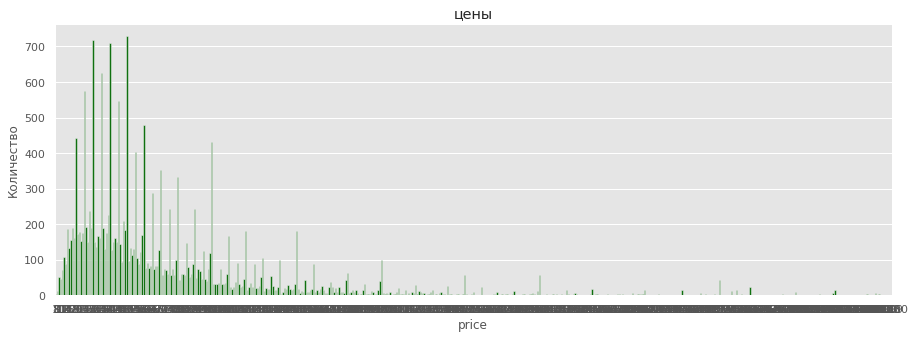

In [29]:
# Распределение параметра price
sns.countplot(x='price', data=df, color='green')
plt.xlabel('price')
plt.ylabel('Количество')
plt.title('цены')

Отрицательно-биномиальное распределение значений параметра price

Text(0.5, 1.0, 'Разброс стоимости жилья')

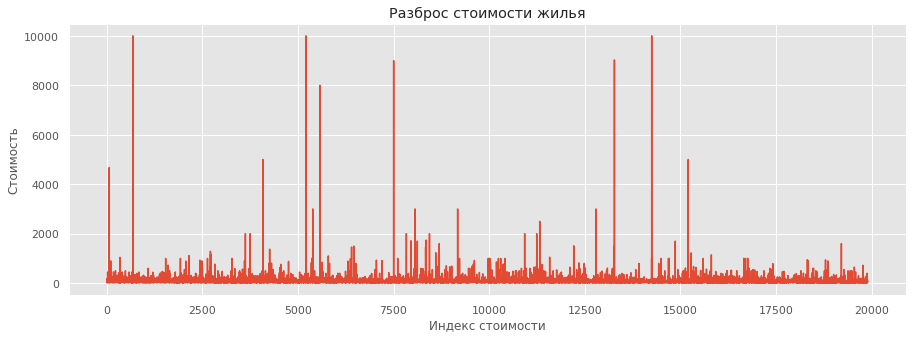

In [30]:
df['price'].plot()
plt.xlabel('Индекс стоимости')
plt.ylabel('Стоимость')
plt.title('Разброс стоимости жилья')

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='price'>

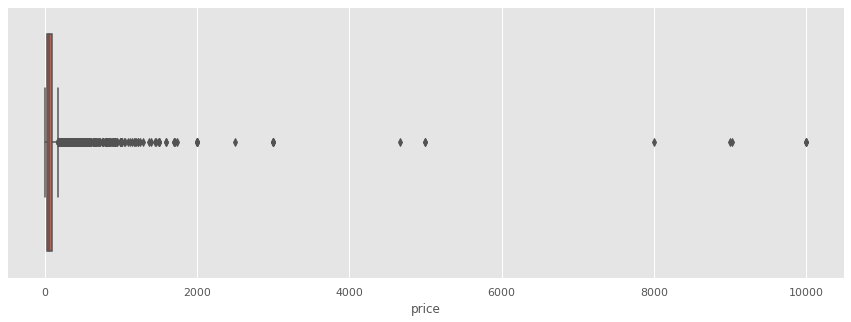

In [31]:
sns.boxplot(df['price'], orient='h')

In [32]:
# Объем нетипичных данных параметра price

df_price = df['price']
upper_quartile = np.percentile(df_price, 75)
lower_quartile = np.percentile(df_price, 25)
iqr = upper_quartile - lower_quartile  #Межквартильный диапазон
upper_whisker = df_price[df_price <= upper_quartile +
                         1.5 * iqr].max()  #1.5 межквартильных диапазона

filtered_emissions = df[
    df['price'] >
    upper_whisker]  #выборка данных с нетипичными значениями стоимости

len(filtered_emissions) / len(
    df
) * 100  #процент нетипичных значений стоимости в генеральной совокупности

7.031917567227946

In [33]:
filtered_emissions['minimum_nights'].value_counts()

1      544
3      288
2      260
30      64
32      60
4       48
5       25
7       19
6       16
14      16
28      14
31      13
15       4
150      4
60       3
90       3
33       2
360      2
34       2
180      2
29       1
135      1
18       1
36       1
12       1
10       1
100      1
120      1
240      1
365      1
Name: minimum_nights, dtype: int64

In [34]:
len(filtered_emissions[filtered_emissions['minimum_nights'] > 29]) / len(
    filtered_emissions) * 100
#процент длительной аренды (от месяца до года) в выборке нетипичной стоимости

11.508220157255183

Анализ описания предложений по параметру name для выявления маркеров премиальной категории

In [35]:
# Приведение регистров символов к общему виду
df['name'] = df['name'].str.lower()  #нижний регистр для всех строк
filtered_emissions['name'] = filtered_emissions['name'].str.lower(
)  #нижний регистр для всех строк
df['name'] = df['name'].str.strip()  #удаление символов в начале и конце строки
df['name'] = df['name'].str.replace('\\.', '')  #удаление точек
df['name'] = df['name'].str.replace('\\bstreet\\b', 'st')  #введение сокращения

<ipython-input-35-f7b8e3e2a962>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emissions['name'] = filtered_emissions['name'].str.lower(


In [36]:
# Поиск наиболее часто встречающихся слов в столбце name генеральной совокупности
Counter(' '.join(df['name']).split()).most_common(10)

[('in', 4725),
 ('room', 4526),
 ('apartment', 3504),
 ('barcelona', 2608),
 ('with', 2213),
 ('the', 2109),
 ('habitación', 1871),
 ('en', 1791),
 ('-', 1671),
 ('de', 1640)]

In [37]:
# Поиск наиболее часто встречающихся слов в столбце name filtered_emissions
Counter(' '.join(filtered_emissions['name']).split()).most_common(10)

[('apartment', 352),
 ('in', 293),
 ('with', 197),
 ('barcelona', 176),
 ('the', 161),
 ('luxury', 108),
 ('de', 107),
 ('-', 101),
 ('room', 99),
 ('terrace', 96)]

In [38]:
# процент предложений с указанием атрибута Lux в генеральной совокупности
df_lux = df[df['name'].str.contains(r'lux*')]
len(df_lux) / len(df) * 100

7.454134204574013

In [39]:
# стандартное отклонение выборки с атрибутом lux
df_lux['price'].std()

378.4141330497012

In [40]:
# процент предложений с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission = filtered_emissions[filtered_emissions['name'].str.contains(
    r'lux*')]
len(df_lux_emission) / len(filtered_emissions) * 100

18.799142244460327

In [41]:
# процент краткосрочной аренды с указанием атрибута Lux в выборке нетипичной стоимости
df_lux_emission_short = df_lux_emission[df_lux_emission['minimum_nights'] < 29]
len(df_lux_emission_short) / len(filtered_emissions) * 100

15.511079342387418

In [42]:
# Группировка стоимости price_class
price_class = {}

price_category = 1

max_price = df['price'].max() + 1

first_quartile = np.percentile(df.price, 25)
second_quartile = np.percentile(df.price, 50)
third_quartile = np.percentile(df.price, 75)
fourth_quartile = upper_whisker
premium = df['price'].max()

for price in range(1, max_price):

    if (price <= first_quartile):
        price_category = 1

    elif (price > first_quartile and price <= second_quartile):
        price_category = 2

    elif (price > second_quartile and price <= third_quartile):
        price_category = 3

    elif (price > third_quartile and price <= fourth_quartile):
        price_category = 4

    elif (price > fourth_quartile and price <= premium):
        price_category = 5

    price_class[price] = price_category

# price_class

In [43]:
# Добавление столбца с номинативными данными категорий стоимости
df['price_class'] = df['price'].map(price_class)

Text(0.5, 1.0, 'Price')

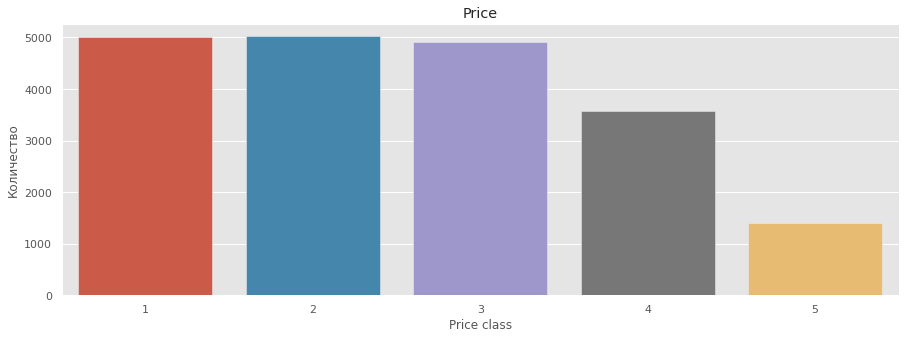

In [44]:
# Распределение параметра price_class
sns.countplot(x='price_class', data=df)
plt.xlabel('Price class')
plt.ylabel('Количество')
plt.title('Price')

#### Анализ параметра name

In [45]:
# Разделение df по категориям из price_class

df_first_price_category=df[df['price_class']==1]
df_second_price_category=df[df['price_class']==2]
df_third_price_category=df[df['price_class']==3]
df_fourth_price_category=df[df['price_class']==4]
df_fifth_price_category=df[df['price_class']==5]

NameError: name 'df_first_price_category' is not defined

In [ ]:
# Поиск наиболее часто встречающихся слов в столбце name 
Counter(' '.join(df_first_price_category['name']).split()).most_common(10)

In [ ]:
Counter(' '.join(df_second_price_category['name']).split()).most_common(10)

In [ ]:
Counter(' '.join(df_third_price_category['name']).split()).most_common(10)

In [ ]:
Counter(' '.join(df_fourth_price_category['name']).split()).most_common(10)

In [ ]:
Counter(' '.join(df_fifth_price_category['name']).split()).most_common(10)

In [ ]:
# Группировка по атрибуту Luxyry
name_class = {}

minimum_nights_category = 1

max_count_nights = df['minimum_nights'].max()

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = 'short_term_rent'

    elif (minimum_nights >= 30):
        minimum_nights_category = 'long_term_rent'

    minimum_nights_class[minimum_nights] = minimum_nights_category

# minimum_nights_class

####                                        Анализ параметра number_of_reviews

In [ ]:
df['number_of_reviews'].describe()

In [ ]:
# Распределение параметра number_of_reviews
df['number_of_reviews'].hist(bins=100)
plt.xlabel('Количество отзывов')
plt.ylabel('Частота')
plt.title('Количество')

In [ ]:
# среднее количество отзывов
df['number_of_reviews'].mean()

In [ ]:
df['number_of_reviews'].max()

In [ ]:
# Группировка по количеству отзывов
number_of_reviews_class = {0: 'no_reviews'}

rank = df['number_of_reviews'].mean()
max_count_review = df['number_of_reviews'].max() + 1

for number_of_reviews in range(1, max_count_review):

    if (number_of_reviews < rank):
        number_of_reviews_category = 'few reviews'

    elif (number_of_reviews >= rank):
        number_of_reviews_category = 'many reviews'

    number_of_reviews_class[number_of_reviews] = number_of_reviews_category

# number_of_reviews_class

In [ ]:
# Добавление столбца с номинативными данными категорий отзывов (без отзывов, более и менее среднего значения)
df['number_of_reviews_class'] = df['number_of_reviews'].map(
    number_of_reviews_class)

####                                  Анализ параметра minimum_nights

In [ ]:
sns.boxplot(df['minimum_nights'], orient='h')

In [ ]:
# Группировка по длительности аренды
minimum_nights_class = {}

minimum_nights_category = 1

max_count_nights = df['minimum_nights'].max()

for minimum_nights in range(1, max_count_nights):

    if (minimum_nights < 30):
        minimum_nights_category = 'short_term_rent'

    elif (minimum_nights >= 30):
        minimum_nights_category = 'long_term_rent'

    minimum_nights_class[minimum_nights] = minimum_nights_category

# minimum_nights_class

In [ ]:
# Добавление столбца с номинативными данными категории длительности аренды  2 категории срока аренды 
# (краткосрочная <30 дней, долгосрочная >30 дней)
df['minimum_nights_class'] = df['minimum_nights'].map(minimum_nights_class)

####                                Анализ параметра neighbourhood_group

In [ ]:
df['neighbourhood_group'].value_counts().plot.bar()

####                                     Анализ параметра availability_365

In [ ]:
# распределение параметра availability_365
df['availability_365'].hist(bins=50)
plt.xlabel('Количество доступных дней для бронирования')
plt.ylabel('Частота')
plt.title('Количество доступных дней для бронирования')

In [ ]:
# Наиболее востребованные районы по availability_365
#выбор 2х столбцов по заданному фильтру
filtered_availability = df[['availability_365', 'neighbourhood_group']]

# жилье недоступное для бронирования
filtered_availability = filtered_availability[
    filtered_availability['availability_365'] == 0]

# Наиболее востребованные районы
X=filtered_availability['neighbourhood_group']
Y=df['neighbourhood_group']

bins = np.linspace(0, 10, 100)

plt.hist(X, bins, alpha=0.5, label='забронировано')
plt.hist(Y, bins, alpha=0.5, label='всего предложений')
plt.legend(loc='upper right')
plt.xlabel('Районы')
plt.ylabel('Количество забронированного жилья')
plt.title('Наиболее востребованные районы')

### Сводная таблица факторов к стоимости

In [ ]:
# оценка корелляции признаков после введения категорий
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, linewidths=1)
plt.show()

Для ответа на ключевой вопрос о взаимосвязи необходимо рассмотреть каждый параметр данных, оценить согласованность данных, установить зависимости, провести оценку их значимости и устранить противоречия.

Сравнить тип жилья, районы, количество отзывов, доступность

In [ ]:
pivot_table_categories = df.pivot_table(values=['price'],
                                        index=[
                                            'neighbourhood_group', 'room_type',
                                            'minimum_nights_class',
                                            'price_class',
                                            'number_of_reviews_class'
                                        ])
pivot_table_categories

In [ ]:
# гистограммы для оценки распределений
df.hist(bins=200);

### Порядковая регрессия

In [ ]:
from bevel.linear_ordinal_regression import OrderedLogit

In [ ]:
# Назначение зависимых(Y) и независимых(X) переменных

Y = df.price_class
X = df[[
    'minimum_nights', 'number_of_reviews', 'reviews_per_month',
    'availability_365', 'latitude', 'longitude',
    'calculated_host_listings_count'
]]

In [ ]:
X.dtypes

In [ ]:
# Построение регрессионной модели
model = OrderedLogit()
model.fit(X, Y)

In [ ]:
model.print_summary()

### Влияние даты последнего отзыва на стоимость

In [ ]:
# корректировка формата даты
df['last_review_dt'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d')

In [ ]:
filtered_emissions['neighbourhood_group'].value_counts().plot.bar()

In [ ]:
df['neighbourhood_group'].value_counts()

In [ ]:
filtered_emissions['room_type'].value_counts()

### Качество данных 
насколько данные пригодны для использования

Достоверность данных - типы данных приведены в соответствие, значения соответствуют названию 

### Неинформативные признаки

### Нерелевантные признаки

In [ ]:
# df.sample(5)

In [ ]:
# import pandas_profiling
# df.profile_report()

In [ ]:
# Кодировка категориальных данных
df.minimum_nights_class = np.where(
    df.minimum_nights_class == 'short_term_rent', 1, 0)

In [ ]:
Y = df.availability_365  #ЗП
X = df.loc[:, [
    'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'price_class'
]]  #НП
X = sm.add_constant(X)  #Intercept

In [ ]:
zeroinf = sm.ZeroInflatedPoisson(Y, X).fit(maxiter=100, method="ncg")
zeroinf.summary()